# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = path.join('..','data','5g_processed_data')
ica_data_dir = path.join('..','data','reICA_low_exAdj_20221031')

# GO and KEGG annotations are in the 'external' folder
external_data = path.join('..','data','external')

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'final_meta_20221031.tsv'),sep='\t')
df_metadata.head()

,sample_id,exp_theme,exp_condition,#sample,shortd,longd,mutation_locus,bior,techr,path_to_FASTQ,...,N-stressed,Fe-stressed,Cu-stressed,EPS,marker_for,cluster_id,project,condition,reference_condition,xorder
0,5GB1_FM03_TR1_QC_tpm,uMax,uMax,5GB1_FM03_TR1_QC,uMax_QC,"Fermentor run 3, uMax though close to O2 limit...",NaN,1.0,1,/work/5GB1c_rnaseq/data/fastq/data.htseq.org/U...,...,NaN,NaN,NaN,NaN,NaN,1,5G,uMax,uMax,1
1,5GB1_FM20_TR1_QC_tpm,uMax,uMax,5GB1_FM20_TR1_QC,uMax_QC,"Fermentor run 20, uMax, QC",NaN,2.0,1,/work/5GB1c_rnaseq/data/fastq/data.htseq.org/U...,...,NaN,NaN,NaN,NaN,NaN,4,5G,uMax,uMax,1
2,5GB1_FM20_TR2_QC_tpm,uMax,uMax,5GB1_FM20_TR2_QC,uMax_QC,"Fermentor run 20, uMax",NaN,2.0,2,/work/5GB1c_rnaseq/data/fastq/data.htseq.org/U...,...,NaN,NaN,NaN,NaN,NaN,3,5G,uMax,uMax,1
3,5GB1_FM20_TR3_tpm,uMax,uMax,5GB1_FM20_TR3,uMax,"Fermentor run 20, uMax",NaN,2.0,3,/work/5GB1c_rnaseq/data/fastq/MY1604291_R2/Sam...,...,NaN,NaN,NaN,NaN,NaN,16,5G,uMax,uMax,1
4,5GB1_FM20_TR3_QC_tpm,uMax,uMax,5GB1_FM20_TR3_QC,uMax_QC,"Fermentor run 20, uMax, QC",NaN,2.0,3,/work/5GB1c_rnaseq/data/fastq/data.htseq.org/U...,...,NaN,NaN,NaN,NaN,NaN,2,5G,uMax,uMax,1


In [4]:
df_metadata.columns

Index(['sample_id', 'exp_theme', 'exp_condition', '#sample', 'shortd', 'longd',
       'mutation_locus', 'bior', 'techr', 'path_to_FASTQ',
       'path_to_FASTQ_paired_end', 'read_length', 'path_to_genome_FASTA',
       'path_to_gff', 'gene_table', 'include?', 'is_qc?', 'comments',
       'secondary_altered_parameters', 'OD', 'Dilution rate (per day)',
       'Abnormal medium? (NMS2 unless indicated otherwise)', 'O2-stressed',
       'N-stressed', 'Fe-stressed', 'Cu-stressed', 'EPS', 'marker_for',
       'cluster_id', 'project', 'condition', 'reference_condition', 'xorder'],
      dtype='object')

In [5]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## ~Check your TRN~ - We have no TRN for 5G!

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [6]:
# df_trn = pd.read_csv(path.join(external_data,'TRN.csv'))
# df_trn.head()

In [7]:
#df_trn[df_trn['regulator'] == 'AbrB']

The `regulator` and `gene_id` must be filled in for each row

In [8]:
# print(df_trn.regulator.notnull().all())
# print(df_trn.gene_id.notnull().all())

## Load the data
You're now ready to load your IcaData object!

In [6]:
m = pd.read_csv(path.join(ica_data_dir,'M.csv'))
m.head()

,locus_tag,0,1,2,3,4,5,6,7,8,...,33,34,35,36,37,38,39,40,41,42
0,EQU24_RS00005,-0.003974,0.013994,-0.003830,0.021574,0.003202,0.008008,0.009013,-0.001347,-0.005334,...,0.004838,-0.006351,-0.000536,0.005914,-0.002205,0.008031,-0.000528,-0.002072,-0.000673,0.000037
1,EQU24_RS00010,0.009581,0.007651,0.000547,0.003589,-0.009304,0.005630,-0.005252,-0.010151,-0.001284,...,-0.010681,-0.008515,0.008426,0.013880,0.006686,0.014819,0.008536,0.002088,0.014764,-0.013541
2,EQU24_RS00015,0.002811,-0.004054,-0.008926,0.006731,-0.008722,0.015330,0.001795,-0.008247,0.001893,...,0.001686,0.008216,-0.002977,0.000274,0.003111,0.001758,-0.012434,-0.004187,0.000271,-0.000998
3,EQU24_RS00020,0.006029,0.000603,-0.004291,0.006313,-0.004906,-0.005172,0.000301,-0.003236,-0.000746,...,-0.008595,-0.006702,0.005828,0.006130,0.003906,-0.008233,0.003046,0.000981,-0.001419,-0.002206
4,EQU24_RS00035,-0.023401,-0.005291,-0.017849,0.000602,-0.011645,0.014698,-0.012146,-0.003034,0.002994,...,-0.001573,-0.013471,0.007766,-0.003011,-0.021646,-0.007231,-0.004178,-0.001710,0.033779,-0.000592


In [7]:
a = pd.read_csv(path.join(ica_data_dir,'A.csv'))
a.head()

,Unnamed: 0,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,5GB1_FM14_TR1_tpm,...,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm,5GB1C_CH4_1000ppm-Rep2_tpm
0,0,9.219409,7.561997,4.934818,3.703958,-7.766171,-7.919578,-11.552087,-11.865233,-2.472243,...,-4.862381,-4.397675,-1.664497,-2.883361,-3.779501,-4.157787,-2.958590,-1.993943,-4.437459,-4.372965
1,1,0.595820,1.486406,0.884891,0.781807,-1.805124,-1.426992,-1.806064,-2.892001,-1.178604,...,-1.467996,0.806569,-3.802546,-3.859721,-5.586852,-3.034297,-5.319838,-6.101501,-5.064008,-5.638519
2,2,-0.615273,-0.237357,-1.097703,-1.024232,0.478442,-0.331058,0.844059,2.383635,1.341214,...,-2.766459,0.020102,-10.815006,-8.566572,-3.218914,-16.324298,0.572787,1.126339,1.655579,1.630608
3,3,-0.248316,-0.243318,-5.289148,-3.963200,-4.712647,-5.275939,-4.632822,-5.262635,-0.750238,...,-7.049107,-6.685679,-6.652223,-6.686090,-7.051433,-7.708900,-1.571939,-1.810954,-2.287139,-1.747209
4,4,-0.278089,0.505677,-0.638748,-0.844527,0.325348,0.453317,0.325265,0.570986,-0.081825,...,5.299743,3.010082,7.967600,7.055339,5.302937,4.916643,3.871369,3.352663,3.157347,1.995064


In [8]:
x = pd.read_csv(path.join(data_dir,'log_norm_uMax_indiv_lowExAdj_filt4ica_20221031.csv'))
x.head()

,locus_tag,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,5GB1_FM14_TR1_tpm,...,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm,5GB1C_CH4_1000ppm-Rep2_tpm
0,EQU24_RS00005,-0.601044,0.047941,-1.049614,-0.502454,-0.649416,-0.641155,-0.645506,-0.595231,-0.253629,...,-0.154942,-0.432784,-0.493871,-0.223650,-0.558950,-0.280948,0.399464,0.373487,-0.284211,0.121865
1,EQU24_RS00010,-0.733380,-0.080914,-0.721494,-0.506424,-0.900744,-0.834632,-0.952361,-0.934059,-0.209876,...,-0.135052,-0.109768,-0.507752,-0.148888,-0.465297,-0.124955,-0.597569,-0.565058,-0.721821,-0.504324
2,EQU24_RS00015,-0.516520,-0.140261,-0.683805,-0.216384,-0.810810,-0.900097,-0.813251,-0.780671,-0.373117,...,-0.398019,-0.424310,-0.697607,-0.365188,-0.587363,-0.136621,-0.092184,-0.258713,-0.736253,-0.397627
3,EQU24_RS00020,-0.649819,0.075143,-0.458800,-0.283088,-0.723023,-0.737316,-0.699194,-0.764430,-0.299210,...,-0.033110,0.067333,-0.151694,0.100365,-0.081217,-0.004456,-0.288024,-0.198564,-0.117120,0.071733
4,EQU24_RS00035,-1.256002,-0.200434,-0.556848,-0.335072,0.071070,0.096697,0.256685,0.297170,0.156125,...,0.769285,0.607397,0.550830,0.745583,0.602460,0.897642,0.317582,0.251670,0.437081,0.769975


In [9]:
# s = pd.read_csv(path.join(data_dir,'final_meta.tsv'),sep='\t',index_col=0)
# s

In [10]:
g = pd.read_csv(path.join(data_dir,'5G_20220411_gene_info.csv'))
g.tail()

,locus_tag,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,tu_id,tu_name,ncbi_protein,gene_name_extra
4175,EQU24_RS23155,hxlA,4877662,4878310,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA
4176,EQU24_RS23160,hxlB,4882314,4882848,-1,6-phospho-3-hexuloisomerase,M,Cell wall/membrane/envelope biogenesis,2436,hxlA // hxlB // tkt,WP_017841572.1,hxlB||hxlB
4177,EQU24_RS23165,hxlA,4882851,4883499,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA
4178,EQU24_RS23170,NaN,4918898,4919603,-1,transposase,L,"Replication, recombination and repair",2460,EQU24_RS23170 // EQU24_RS21795 // EQU24_RS2179...,WP_017841541.1,||None
4179,EQU24_RS23175,NaN,4919710,4919809,1,type II toxin-antitoxin system RelE/ParE famil...,X,No COG annotation,2461,EQU24_RS21810 // EQU24_RS23175,WP_083877756.1,||None


In [14]:
# ERIN: change this to the new M and A?
# ica_data = IcaData(M = path.join(ica_data_dir,'M.csv'),
#                    A = path.join(ica_data_dir,'A.csv'),
#                    X = path.join(data_dir,'5g_log_tpm_norm_indiv.csv'),
#                    gene_table = path.join(data_dir,'5G_gene_info2.csv'),
#                    sample_table = path.join(data_dir,'final_meta.tsv'),
#                    #trn = path.join(external_data,'TRN.csv'),
#                    optimize_cutoff=True)

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [11]:
# ERIN: ah, I'll use this version for 5g? bc no TRN

ica_data = IcaData(M = path.join(ica_data_dir,'M.csv'),
                   A = path.join(ica_data_dir,'A.csv'),
                   #X = path.join(data_dir,'5g_log_tpm_norm_indiv.csv'),
                   X = path.join(data_dir,'log_norm_uMax_indiv_lowExAdj_filt4ica_20221031.csv'),
                   gene_table = path.join(data_dir,'5G_20220411_gene_info.csv'),
                   sample_table = path.join(data_dir,'final_meta_20221031.tsv'),
                   #trn = path.join(data_dir,'TRN.csv'),
                   threshold_method = 'kmeans')

In [12]:
ica_data.gene_table[ica_data.gene_table.index == "EQU24_RS18140"]

,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,tu_id,tu_name,ncbi_protein,gene_name_extra
EQU24_RS18140,moxF,4043061,4044870,-1,methanol/ethanol family PQQ-dependent dehydrog...,G,Carbohydrate transport and metabolism,2031,EQU24_RS18140,WP_017842205.1,||None


# ~Regulatory iModulons~ I don't have TRN, so skip this
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [19]:
#ica_data.compute_trn_enrichment()

You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [20]:
# First search for regulator enrichments with 2 regulators
# ica_data.compute_trn_enrichment(max_regs=2,save=True)

# # Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
# ica_data.compute_trn_enrichment(max_regs=1,save=True)

The list of regulatory iModulons are shown below

In [21]:
# regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
# print(len(ica_data.imodulon_table),'Total iModulons')
# print(len(regulatory_imodulons),'Regulatory iModulons')
# regulatory_imodulons

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [22]:
# ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
# ica_data.imodulon_table.head()

In [23]:
# regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

GO annotations and KEGG pathways/modules were generated in the 1_create_the_gene_table.ipynb notebook. Enrichments will be calculated in this notebook, and further curated in the 3_manual_iModulon_curation notebook.

## GO Enrichments

First load the Gene Ontology annotations

In [29]:
#DF_GO = pd.read_csv(path.join(external_data,'5G_GO_annotations_from_egg.csv'),index_col=0)
DF_GO = pd.read_csv(path.join(external_data,'5G_go_combined_melt_20220411.tsv'),sep='\t').fillna("")
print(DF_GO.shape)
DF_GO.head()

(12222, 3)


,locus_tag,go_id,go_name
0,EQU24_RS00005,GO:0006270,DNA replication initiation
1,EQU24_RS00005,GO:0005737,cytoplasm
2,EQU24_RS00005,GO:0003688,DNA replication origin binding
3,EQU24_RS00005,GO:0005524,ATP binding
4,EQU24_RS00005,GO:0006275,regulation of DNA replication


In [44]:
# remove rows from DFGO that weren't in new genome?
DF_GO = DF_GO[DF_GO['locus_tag'].isin(ica_data.gene_names)]
DF_GO.shape

(11954, 5)

In [45]:
# i think IcaData object needs 'gene_id' column
DF_GO['gene_id'] = DF_GO['locus_tag']
DF_GO.head(15)

/home/ewilson6/anaconda3/envs/modulome/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,locus_tag,go_id,go_name,gene_id,go_level
0,EQU24_RS00005,GO:0006270,DNA replication initiation,EQU24_RS00005,5
1,EQU24_RS00005,GO:0005737,cytoplasm,EQU24_RS00005,2
2,EQU24_RS00005,GO:0003688,DNA replication origin binding,EQU24_RS00005,7
3,EQU24_RS00005,GO:0005524,ATP binding,EQU24_RS00005,5
4,EQU24_RS00005,GO:0006275,regulation of DNA replication,EQU24_RS00005,6
5,EQU24_RS00010,GO:0005737,cytoplasm,EQU24_RS00010,2
6,EQU24_RS00010,GO:0003887,DNA-directed DNA polymerase activity,EQU24_RS00010,5
7,EQU24_RS00010,GO:0008408,3'-5' exonuclease activity,EQU24_RS00010,6
8,EQU24_RS00010,GO:0090305,nucleic acid phosphodiester bond hydrolysis,EQU24_RS00010,5
9,EQU24_RS00010,GO:0003677,DNA binding,EQU24_RS00010,4


### add the top 5 go annotations to the ica_data.gene_table


In [46]:
ica_data.gene_table

,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,tu_id,tu_name,ncbi_protein,gene_name_extra,specific_gos_n,specific_gos
EQU24_RS00005,dnaA,0,1317,1,chromosomal replication initiator protein DnaA,L,"Replication, recombination and repair",1,dnaN // dnaA,WP_017841472.1,dnaA||dnaA,DNA replication origin binding\nregulation of ...,"[DNA replication origin binding, regulation of..."
EQU24_RS00010,dnaN,1502,2603,1,DNA polymerase III subunit beta,L,"Replication, recombination and repair",1,dnaN // dnaA,WP_017841471.1,dnaN||dnaN,3'-5' exonuclease activity\nDNA-directed DNA p...,"[3'-5' exonuclease activity, DNA-directed DNA ..."
EQU24_RS00015,recF,3060,4140,1,DNA replication/repair protein RecF,L,"Replication, recombination and repair",2,recF,WP_017841470.1,recF||recF,DNA replication\nATP binding\nsingle-stranded ...,"[DNA replication, ATP binding, single-stranded..."
EQU24_RS00020,gyrB,4185,6600,1,DNA topoisomerase (ATP-hydrolyzing) subunit B,L,"Replication, recombination and repair",3,gyrB,WP_017841469.1,gyrB||gyrB,DNA-templated DNA replication\nchromosome\nATP...,"[DNA-templated DNA replication, chromosome, AT..."
EQU24_RS00035,NaN,7350,7734,1,hypothetical protein,X,No COG annotation,4,EQU24_RS00035,WP_014146528.1,||None,,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS23155,hxlA,4877662,4878310,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA,,[]
EQU24_RS23160,hxlB,4882314,4882848,-1,6-phospho-3-hexuloisomerase,M,Cell wall/membrane/envelope biogenesis,2436,hxlA // hxlB // tkt,WP_017841572.1,hxlB||hxlB,,[]
EQU24_RS23165,hxlA,4882851,4883499,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA,,[]
EQU24_RS23170,NaN,4918898,4919603,-1,transposase,L,"Replication, recombination and repair",2460,EQU24_RS23170 // EQU24_RS21795 // EQU24_RS2179...,WP_017841541.1,||None,,[]


In [47]:
from goatools import obo_parser
import os
go_file = os.path.join('..','data','external','GO_20220505.txt')
p = obo_parser.GODag(go_file)

../data/external/GO_20220505.txt: fmt(1.2) rel(2022-03-22) 47,103 Terms


In [48]:
def get_top_k_gos(gene_table, k):
    '''
    Given a table of genes, get the top k most specific GO terms
    '''
    def get_go_level(go_id):
        try:
            return p[go_id].level
        except:
            return -1 # not in go dag

    DF_GO['go_level'] = DF_GO['go_id'].apply(lambda x: get_go_level(x))

    # loop through genes in gene table to get top k go term names
    loc2top_gos = {}
    for _,row in gene_table.iterrows():
        locus_tag = row.name
        gene_gos = DF_GO[DF_GO['locus_tag']==locus_tag].sort_values('go_level',ascending=False).head(k)
        go_terms = gene_gos['go_name'].values
        loc2top_gos[locus_tag] = go_terms

    # add gos to gene table
    #gene_table['specific_gos'] = gene_table.reset_index()['index'].apply(lambda x: loc2top_gos[x])
    return loc2top_gos
    

        

In [49]:
top5gos = get_top_k_gos(ica_data.gene_table, 5)

/home/ewilson6/anaconda3/envs/modulome/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [50]:
DF_GO[DF_GO['locus_tag']=='EQU24_RS19310'].sort_values('go_level',ascending=False).head(5)

,locus_tag,go_id,go_name,gene_id,go_level
10760,EQU24_RS19310,GO:0015049,methane monooxygenase activity,EQU24_RS19310,5
10748,EQU24_RS19310,GO:0015947,methane metabolic process,EQU24_RS19310,4
10750,EQU24_RS19310,GO:0015050,methane monooxygenase complex,EQU24_RS19310,4
10762,EQU24_RS19310,GO:0016709,"oxidoreductase activity, acting on paired dono...",EQU24_RS19310,4
10751,EQU24_RS19310,GO:0016705,"oxidoreductase activity, acting on paired dono...",EQU24_RS19310,3


In [51]:
'\n'.join(list(top5gos['EQU24_RS00005']))

'DNA replication origin binding\nregulation of DNA replication\nDNA replication initiation\nATP binding\ncytoplasm'

In [52]:
ica_data.gene_table['specific_gos_n'] = ica_data.gene_table.apply(lambda row: '\n'.join(top5gos[row.name]),axis=1)
ica_data.gene_table['specific_gos'] = ica_data.gene_table.apply(lambda row: top5gos[row.name],axis=1)

In [53]:
ica_data.gene_table.reset_index()

,index,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,tu_id,tu_name,ncbi_protein,gene_name_extra,specific_gos_n,specific_gos
0,EQU24_RS00005,dnaA,0,1317,1,chromosomal replication initiator protein DnaA,L,"Replication, recombination and repair",1,dnaN // dnaA,WP_017841472.1,dnaA||dnaA,DNA replication origin binding\nregulation of ...,"[DNA replication origin binding, regulation of..."
1,EQU24_RS00010,dnaN,1502,2603,1,DNA polymerase III subunit beta,L,"Replication, recombination and repair",1,dnaN // dnaA,WP_017841471.1,dnaN||dnaN,3'-5' exonuclease activity\nDNA-directed DNA p...,"[3'-5' exonuclease activity, DNA-directed DNA ..."
2,EQU24_RS00015,recF,3060,4140,1,DNA replication/repair protein RecF,L,"Replication, recombination and repair",2,recF,WP_017841470.1,recF||recF,DNA replication\nATP binding\nsingle-stranded ...,"[DNA replication, ATP binding, single-stranded..."
3,EQU24_RS00020,gyrB,4185,6600,1,DNA topoisomerase (ATP-hydrolyzing) subunit B,L,"Replication, recombination and repair",3,gyrB,WP_017841469.1,gyrB||gyrB,DNA-templated DNA replication\nchromosome\nATP...,"[DNA-templated DNA replication, chromosome, AT..."
4,EQU24_RS00035,NaN,7350,7734,1,hypothetical protein,X,No COG annotation,4,EQU24_RS00035,WP_014146528.1,||None,,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,EQU24_RS23155,hxlA,4877662,4878310,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA,,[]
4176,EQU24_RS23160,hxlB,4882314,4882848,-1,6-phospho-3-hexuloisomerase,M,Cell wall/membrane/envelope biogenesis,2436,hxlA // hxlB // tkt,WP_017841572.1,hxlB||hxlB,,[]
4177,EQU24_RS23165,hxlA,4882851,4883499,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA,,[]
4178,EQU24_RS23170,NaN,4918898,4919603,-1,transposase,L,"Replication, recombination and repair",2460,EQU24_RS23170 // EQU24_RS21795 // EQU24_RS2179...,WP_017841541.1,||None,,[]


In [54]:
# calculate GO enrichment
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'go_name')

In [55]:
DF_GO_enrich

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,3,sulfate transmembrane transport,4.144723e-07,8.865563e-04,0.033708,0.666667,0.064171,6.0,9.0,178.0
1,3,ABC-type sulfate transporter activity,3.183189e-06,3.404421e-03,0.022472,1.000000,0.043956,4.0,4.0,178.0
2,4,methane metabolic process,6.635245e-13,1.419279e-09,0.555556,0.625000,0.588235,5.0,8.0,9.0
3,4,methane monooxygenase activity,1.491737e-12,1.595413e-09,0.555556,0.555556,0.555556,5.0,9.0,9.0
4,4,monooxygenase activity,5.460966e-12,3.893669e-09,0.555556,0.454545,0.500000,5.0,11.0,9.0
...,...,...,...,...,...,...,...,...,...,...
56,31,carbonyl sulfide nitrogenase activity,2.305355e-08,1.232789e-05,0.075472,1.000000,0.140351,4.0,4.0,53.0
57,31,electron transfer activity,4.565868e-07,1.953278e-04,0.150943,0.137931,0.144144,8.0,58.0,53.0
58,31,iron-sulfur cluster binding,1.796797e-06,6.405582e-04,0.113208,0.193548,0.142857,6.0,31.0,53.0
59,31,molybdenum-iron nitrogenase complex,1.577722e-04,4.821069e-02,0.037736,1.000000,0.072727,2.0,2.0,53.0


In [56]:
#old
DF_GO_enrich['imodulon'].value_counts()

4     20
20     7
21     7
31     7
25     6
5      3
12     3
3      2
6      2
30     2
11     1
37     1
Name: imodulon, dtype: int64

In [36]:
#new
DF_GO_enrich['imodulon'].value_counts()

40    191
15    115
1      10
26     10
19      7
39      6
0       4
33      4
17      3
6       2
18      2
35      2
8       1
29      1
31      1
37      1
Name: imodulon, dtype: int64

In [60]:
DF_GO_enrich[DF_GO_enrich['imodulon'] ==20]

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
31,20,regulation of nitrogen utilization,0.000014,0.029114,0.078947,0.500000,0.136364,3.0,6.0,38.0
32,20,ammonium transmembrane transport,0.000080,0.034433,0.052632,1.000000,0.100000,2.0,2.0,38.0
33,20,ammonium transmembrane transporter activity,0.000080,0.034433,0.052632,1.000000,0.100000,2.0,2.0,38.0
34,20,nitrate assimilation,0.000080,0.034433,0.052632,1.000000,0.100000,2.0,2.0,38.0
35,20,nitrite reductase [NAD(P)H] activity,0.000080,0.034433,0.052632,1.000000,0.100000,2.0,2.0,38.0
36,20,urea catabolic process,0.000240,0.073362,0.052632,0.666667,0.097561,2.0,3.0,38.0
37,20,urease activity,0.000240,0.073362,0.052632,0.666667,0.097561,2.0,3.0,38.0


In [61]:
DF_GO_enrich.sort_values('pvalue')#.head()

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
53,31,nitrogen fixation,1.272941e-24,2.722820e-21,0.264151,0.777778,0.394366,14.0,18.0,53.0
38,21,bacterial-type flagellum-dependent cell motility,4.730425e-17,1.011838e-13,0.106061,0.666667,0.183007,14.0,21.0,132.0
2,4,methane metabolic process,6.635245e-13,1.419279e-09,0.555556,0.625000,0.588235,5.0,8.0,9.0
60,37,cobalamin biosynthetic process,1.328640e-12,2.841962e-09,0.076923,0.611111,0.136646,11.0,18.0,143.0
3,4,methane monooxygenase activity,1.491737e-12,1.595413e-09,0.555556,0.555556,0.555556,5.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...
50,25,response to heat,1.045692e-04,3.727892e-02,0.111111,0.500000,0.181818,2.0,4.0,18.0
21,4,,1.062755e-04,1.136616e-02,0.555556,0.018657,0.036101,5.0,297.0,9.0
59,31,molybdenum-iron nitrogenase complex,1.577722e-04,4.821069e-02,0.037736,1.000000,0.072727,2.0,2.0,53.0
36,20,urea catabolic process,2.400800e-04,7.336159e-02,0.052632,0.666667,0.097561,2.0,3.0,38.0


## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [63]:
DF_KEGG = pd.read_csv('../data/external/5G_20220411_kegg_mapping.csv',index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
2093,EQU24_RS00005,KEGG_pathway,map02020
2094,EQU24_RS00005,KEGG_pathway,map04112
2101,EQU24_RS00010,KEGG_pathway,map00230
2102,EQU24_RS00010,KEGG_pathway,map00240
2103,EQU24_RS00010,KEGG_pathway,map01100


In [64]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [65]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [66]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,map01220,2.383755e-15,5.053561e-13,0.666667,0.600000,0.631579,6.0,10.0,9.0
1,4,map00680,9.061628e-10,9.605326e-08,0.666667,0.092308,0.162162,6.0,65.0,9.0
2,4,map01200,4.278781e-08,3.023672e-06,0.666667,0.049180,0.091603,6.0,122.0,9.0
3,4,map01120,1.048100e-06,5.554931e-05,0.666667,0.028846,0.055300,6.0,208.0,9.0
4,4,map01100,3.799451e-04,1.610967e-02,0.666667,0.010453,0.020583,6.0,574.0,9.0


In [67]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,M00641,8.763778e-07,2.050724e-04,0.073171,1.000000,0.136364,3.0,3.0,41.0
1,1,M00701,9.388478e-05,1.098452e-02,0.048780,1.000000,0.093023,2.0,2.0,41.0
2,3,M00185,3.183189e-06,7.448662e-04,0.022472,1.000000,0.043956,4.0,4.0,178.0
3,4,M00174,1.047559e-14,2.451289e-12,0.666667,0.500000,0.571429,6.0,12.0,9.0
4,5,M00178,3.148384e-06,7.367219e-04,0.058296,0.240741,0.093863,13.0,54.0,223.0


### Convert KEGG IDs to human-readable names

In [68]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [69]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map01220,2.383755e-15,5.053561e-13,0.666667,0.600000,0.631579,6.0,10.0,9.0,Degradation of aromatic compounds
1,4,map00680,9.061628e-10,9.605326e-08,0.666667,0.092308,0.162162,6.0,65.0,9.0,Methane metabolism
2,4,map01200,4.278781e-08,3.023672e-06,0.666667,0.049180,0.091603,6.0,122.0,9.0,Carbon metabolism
3,4,map01120,1.048100e-06,5.554931e-05,0.666667,0.028846,0.055300,6.0,208.0,9.0,Microbial metabolism in diverse environments
4,4,map01100,3.799451e-04,1.610967e-02,0.666667,0.010453,0.020583,6.0,574.0,9.0,Metabolic pathways


In [70]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,1,M00641,8.763778e-07,2.050724e-04,0.073171,1.000000,0.136364,3.0,3.0,41.0,"Multidrug resistance, efflux pump MexEF-OprN"
1,1,M00701,9.388478e-05,1.098452e-02,0.048780,1.000000,0.093023,2.0,2.0,41.0,None
2,3,M00185,3.183189e-06,7.448662e-04,0.022472,1.000000,0.043956,4.0,4.0,178.0,None
3,4,M00174,1.047559e-14,2.451289e-12,0.666667,0.500000,0.571429,6.0,12.0,9.0,"Methane oxidation, methanotroph, methane => fo..."
4,5,M00178,3.148384e-06,7.367219e-04,0.058296,0.240741,0.093863,13.0,54.0,223.0,None


In [73]:
DF_pathway_enrich[DF_pathway_enrich['imodulon'] == 4]

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map01220,2.383755e-15,5.053561e-13,0.666667,0.600000,0.631579,6.0,10.0,9.0,Degradation of aromatic compounds
1,4,map00680,9.061628e-10,9.605326e-08,0.666667,0.092308,0.162162,6.0,65.0,9.0,Methane metabolism
2,4,map01200,4.278781e-08,3.023672e-06,0.666667,0.049180,0.091603,6.0,122.0,9.0,Carbon metabolism
3,4,map01120,1.048100e-06,5.554931e-05,0.666667,0.028846,0.055300,6.0,208.0,9.0,Microbial metabolism in diverse environments
4,4,map01100,3.799451e-04,1.610967e-02,0.666667,0.010453,0.020583,6.0,574.0,9.0,Metabolic pathways


## Save files

In [75]:
DF_GO_enrich['source'] = 'GO'
DF_pathway_enrich['source'] = 'KEGG pathways'
DF_module_enrich['source'] = 'KEGG modules'
# DF_subti_enrich['source'] = 'SubtiWiki'

DF_GO_enrich.rename({'gene_ontology':'annotation'},axis=1, inplace=True)
DF_pathway_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
DF_module_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
# DF_subti_enrich.rename({'value':'annotation'},axis=1, inplace=True)

#DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich, DF_subti_enrich])
DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich])
#DF_enrichments.to_csv(path.join(data_dir,'5G_functional_enrichments.csv'))
DF_enrichments.to_csv(path.join(data_dir,'5G_functional_enrichments_20221031.csv'))

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [76]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

10

In [77]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [78]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,single_gene
SG_1,True
SG_2,True
SG_3,True
SG_4,True
SG_5,True
SG_6,True
SG_7,True
SG_8,True
SG_9,True
SG_10,True


In [79]:
ica_data.imodulon_table

,single_gene
0,NaN
1,NaN
SG_1,True
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
SG_2,True


In [80]:
ica_data.view_imodulon('SG_8')

,gene_weight,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,tu_id,tu_name,ncbi_protein,gene_name_extra,specific_gos_n,specific_gos
EQU24_RS23065,0.599443,NaN,3883242,3883440,-1,hypothetical protein,X,No COG annotation,1949,EQU24_RS23065 // EQU24_RS17315 // EQU24_RS1731...,WP_017842364.1,||None,,[]


# Save iModulon object

In [81]:
from pymodulon.util import explained_variance
from pymodulon.io import *

In [82]:
# Add iModulon sizes and explained variance
for im in ica_data.imodulon_names:
    ica_data.imodulon_table.loc[im,'imodulon_size'] = len(ica_data.view_imodulon(im))
    ica_data.imodulon_table.loc[im,'explained_variance'] = explained_variance(ica_data,imodulons=im)

In [83]:
ica_data.gene_table

,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,tu_id,tu_name,ncbi_protein,gene_name_extra,specific_gos_n,specific_gos
EQU24_RS00005,dnaA,0,1317,1,chromosomal replication initiator protein DnaA,L,"Replication, recombination and repair",1,dnaN // dnaA,WP_017841472.1,dnaA||dnaA,DNA replication origin binding\nregulation of ...,"[DNA replication origin binding, regulation of..."
EQU24_RS00010,dnaN,1502,2603,1,DNA polymerase III subunit beta,L,"Replication, recombination and repair",1,dnaN // dnaA,WP_017841471.1,dnaN||dnaN,3'-5' exonuclease activity\nDNA-directed DNA p...,"[3'-5' exonuclease activity, DNA-directed DNA ..."
EQU24_RS00015,recF,3060,4140,1,DNA replication/repair protein RecF,L,"Replication, recombination and repair",2,recF,WP_017841470.1,recF||recF,DNA replication\nATP binding\nsingle-stranded ...,"[DNA replication, ATP binding, single-stranded..."
EQU24_RS00020,gyrB,4185,6600,1,DNA topoisomerase (ATP-hydrolyzing) subunit B,L,"Replication, recombination and repair",3,gyrB,WP_017841469.1,gyrB||gyrB,DNA-templated DNA replication\nchromosome\nATP...,"[DNA-templated DNA replication, chromosome, AT..."
EQU24_RS00035,NaN,7350,7734,1,hypothetical protein,X,No COG annotation,4,EQU24_RS00035,WP_014146528.1,||None,,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS23155,hxlA,4877662,4878310,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA,,[]
EQU24_RS23160,hxlB,4882314,4882848,-1,6-phospho-3-hexuloisomerase,M,Cell wall/membrane/envelope biogenesis,2436,hxlA // hxlB // tkt,WP_017841572.1,hxlB||hxlB,,[]
EQU24_RS23165,hxlA,4882851,4883499,-1,3-hexulose-6-phosphate synthase,G,Carbohydrate transport and metabolism,2436,hxlA // hxlB // tkt,WP_017841571.1,hxlA||hxlA,,[]
EQU24_RS23170,NaN,4918898,4919603,-1,transposase,L,"Replication, recombination and repair",2460,EQU24_RS23170 // EQU24_RS21795 // EQU24_RS2179...,WP_017841541.1,||None,,[]


This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [84]:
save_to_json(ica_data, path.join('..','data','5g_processed_data','5g_raw_20221031.json.gz'))

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [85]:
ica_data.imodulon_table.to_csv(path.join('..','data','5g_processed_data','5g_imodulon_table_raw_20221031.csv'))

## Explore ICA data object more?

In [86]:
ica_data.imodulon_table.sort_values('imodulon_size')

,single_gene,imodulon_size,explained_variance
SG_6,True,1.0,0.003657
SG_5,True,1.0,0.002279
SG_4,True,1.0,0.004787
SG_2,True,1.0,0.006651
SG_10,True,1.0,0.003801
SG_3,True,1.0,0.001951
SG_8,True,1.0,0.002887
SG_7,True,2.0,0.003649
42,,3.0,0.002239
SG_9,True,3.0,0.002735


In [87]:
import seaborn as sns

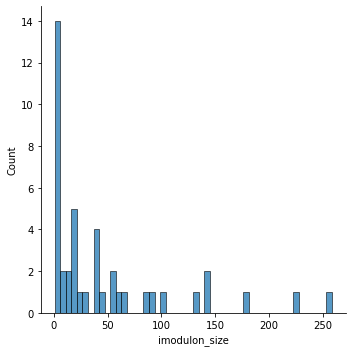

In [88]:
sns.displot(ica_data.imodulon_table['imodulon_size'],bins=50)

In [89]:
ica_data.imodulon_table.shape

(43, 3)

In [90]:
import matplotlib.pyplot as plt

(array([0.27906977, 0.41860465, 0.46511628, 0.55813953, 0.62790698,
        0.65116279, 0.65116279, 0.65116279, 0.69767442, 0.74418605,
        0.74418605, 0.76744186, 0.76744186, 0.79069767, 0.79069767,
        0.81395349, 0.81395349, 0.81395349, 0.8372093 , 0.8372093 ,
        0.86046512, 0.86046512, 0.88372093, 0.93023256, 0.95348837,
        0.95348837, 0.95348837, 0.95348837, 0.97674419, 1.        ]),
 array([0.00195091, 0.00438847, 0.00682604, 0.00926361, 0.01170117,
        0.01413874, 0.01657631, 0.01901387, 0.02145144, 0.023889  ,
        0.02632657, 0.02876414, 0.0312017 , 0.03363927, 0.03607684,
        0.0385144 , 0.04095197, 0.04338954, 0.0458271 , 0.04826467,
        0.05070223, 0.0531398 , 0.05557737, 0.05801493, 0.0604525 ,
        0.06289007, 0.06532763, 0.0677652 , 0.07020277, 0.07264033,
        0.0750779 ]),
 <BarContainer object of 30 artists>)

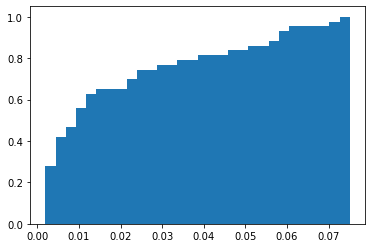

In [91]:
x = ica_data.imodulon_table.sort_values('explained_variance',ascending=False)['explained_variance']
plt.hist(x,cumulative=True, density=True, bins=30)

<AxesSubplot:xlabel='explained_variance', ylabel='Proportion'>

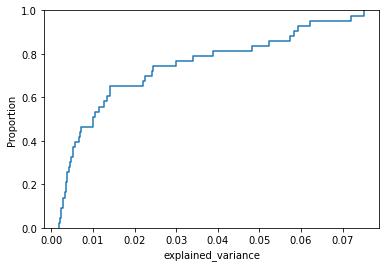

In [92]:
sns.ecdfplot(data=ica_data.imodulon_table, x='explained_variance')

In [93]:
ica_data.imodulon_table.sort_values('explained_variance',ascending=False)

,single_gene,imodulon_size,explained_variance
20,,38.0,0.075078
37,,143.0,0.072090
8,,20.0,0.062186
6,,99.0,0.059165
35,,18.0,0.058357
4,,9.0,0.057266
5,,223.0,0.052252
12,,45.0,0.048211
31,,53.0,0.038944
21,,132.0,0.033934


Text(0, 0.5, 'Explained Variance')

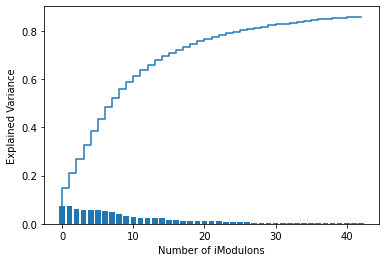

In [94]:
cx = list(zip(*enumerate(np.cumsum(x.values))))
plt.step(cx[0],cx[1])
plt.bar(cx[0],x.values)
plt.xlabel('Number of iModulons')
plt.ylabel('Explained Variance')

In [95]:
cx

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42),
 (0.07507789838796752,
  0.14716809857930435,
  0.2093536219371671,
  0.26851819382332,
  0.32687515351155194,
  0.38414142503090953,
  0.43639382299020946,
  0.4846049572204002,
  0.5235485315796343,
  0.5574821962297275,
  0.5874314487801431,
  0.6118283959848678,
  0.6359392191480265,
  0.6583673893480304,
  0.6803848808567258,
  0.6946010114484926,
  0.7087370991504074,
  0.7220014901543078,
  0.7346294131007264,
  0.7460955169631167,
  0.7565139830520439,
  0.7666397671891682,
  0.7767106016076981,
  0.7838339915304173,
  0.7906907216583475,
  0.7973416324060583,
  0.8029278981058386,
  0.8081669470170839,
  0.8133041369670286,
  0.8180907532356361,
  0.8226029466947674,
  0.82674794144122,
  0.830548522696183,
  0.8342052641558055,
  0

<AxesSubplot:xlabel='imodulon_size', ylabel='explained_variance'>

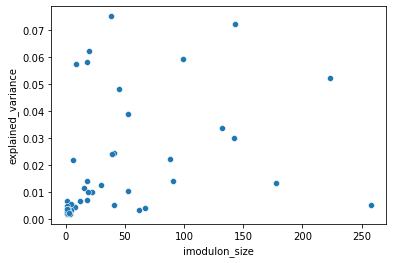

In [96]:
sns.scatterplot(data=ica_data.imodulon_table, x='imodulon_size',y='explained_variance')

In [97]:
import altair as alt

In [98]:
idx=29
ica_data.view_imodulon(idx)[['product','gene_weight','tu_name','gene_name_extra']]

,product,gene_weight,tu_name,gene_name_extra
EQU24_RS00305,response regulator,0.112791,EQU24_RS00310 // EQU24_RS00305 // EQU24_RS00300,||None
EQU24_RS00310,EAL domain-containing protein,0.080007,EQU24_RS00310 // EQU24_RS00305 // EQU24_RS00300,||None
EQU24_RS01375,hypothetical protein,-0.061608,EQU24_RS01375,||None
EQU24_RS03035,membrane protein insertion efficiency factor YidD,0.106101,yidD,yidD||yidD
EQU24_RS03040,hypothetical protein,0.209046,EQU24_RS03040,||None
EQU24_RS06665,hypothetical protein,0.072940,EQU24_RS06680 // EQU24_RS06675 // EQU24_RS0667...,||None
EQU24_RS06670,hypothetical protein,0.079081,EQU24_RS06680 // EQU24_RS06675 // EQU24_RS0667...,||None
EQU24_RS06675,ATP/GTP-binding protein,0.087170,EQU24_RS06680 // EQU24_RS06675 // EQU24_RS0667...,||None
EQU24_RS06680,hypothetical protein,0.088636,EQU24_RS06680 // EQU24_RS06675 // EQU24_RS0667...,||None
EQU24_RS06685,roadblock/LC7 domain-containing protein,0.082332,EQU24_RS06695 // EQU24_RS06690 // EQU24_RS06685,||None


In [99]:
DF_enrichments[DF_enrichments['imodulon']==idx]

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,annotation,pathway_name,module_name


In [100]:
ica_data.imodulon_table[ica_data.imodulon_table.index ==idx]

,single_gene,imodulon_size,explained_variance
29,,39.0,0.024111
